In [ ]:
data_source = "path"
df_temp = spark.read.option('header',True).csv(data_source)
df_temp.cache()
df_temp.count()
df_temp.createOrReplaceTempView('raw_info')

In [55]:
df_temp.where(F.col('Class') == 'Attack').select('DLC', 'Timestamp').groupBy('DLC').agg(F.count(F.col('Timestamp')).alias('count')).orderBy('DLC').show(100,False)

+---+------+
|DLC|count |
+---+------+
|2  |80    |
|4  |3985  |
|5  |991   |
|6  |2080  |
|7  |5857  |
|8  |286415|
+---+------+



In [3]:
spark.sql("""
select Arbitration_ID, count(distinct Timestamp) as count_log
from raw_info
group by 1
order by 2
""").show(10,False)

+--------------+---------+
|Arbitration_ID|count_log|
+--------------+---------+
|7D4           |1013     |
|7D0           |1014     |
|7C4           |1025     |
|7CC           |1053     |
|7DC           |1054     |
|7D8           |1109     |
|4A4           |1154     |
|57F           |1707     |
|5BE           |2364     |
|5B0           |2394     |
+--------------+---------+
only showing top 10 rows



In [ ]:
def change_to_list(data):
    return_list = [0] * 16*16
    for i in data:
        index = int('0x'+i, 16)
        return_list.append(index)
    return return_list

change = F.udf(lambda x: change_to_list(x), ArrayType(IntegerType()))

In [3]:
def change_to_list(data):
    return_list = []
    for i in data:
        index = int('0x'+i, 16)
        return_list.append(index)
    return return_list

change = F.udf(lambda x: change_to_list(x), ArrayType(IntegerType()))

In [167]:
df_temp\
    .withColumn('Data', change(F.split(F.col('Data'), ' ')))\
    .select('Timestamp', 'Arbitration_ID', F.col('DLC').cast(IntegerType()),
            F.col('Data')[0].alias('CAN1'),
           F.col('Data')[1].alias('CAN2'),
           F.col('Data')[2].alias('CAN3'),
           F.col('Data')[3].alias('CAN4'),
           F.col('Data')[4].alias('CAN5'),
           F.col('Data')[5].alias('CAN6'),
           F.col('Data')[6].alias('CAN7'),
           F.col('Data')[7].alias('CAN8'),
            F.when(F.col('Class') == 'Normal', 0).otherwise(1).alias('label')).fillna(0).createOrReplaceTempView('temp')

In [99]:
# CANID 변화량
train_df = spark.sql("""
select *,
    CAN1 - lag(CAN1) over(partition by Arbitration_ID order by Timestamp) as diff_CAN1,
    CAN2 - lag(CAN2) over(partition by Arbitration_ID order by Timestamp) as diff_CAN2,
    CAN3 - lag(CAN3) over(partition by Arbitration_ID order by Timestamp) as diff_CAN3,
    CAN4 - lag(CAN4) over(partition by Arbitration_ID order by Timestamp) as diff_CAN4,
    CAN5 - lag(CAN5) over(partition by Arbitration_ID order by Timestamp) as diff_CAN5,
    CAN6 - lag(CAN6) over(partition by Arbitration_ID order by Timestamp) as diff_CAN6,
    CAN7 - lag(CAN7) over(partition by Arbitration_ID order by Timestamp) as diff_CAN7,
    CAN8 - lag(CAN8) over(partition by Arbitration_ID order by Timestamp) as diff_CAN8
from temp
""").fillna(0).toPandas()

+-----------------+--------------+---+----+----+----+----+----+----+----+----+-----+---------+---------+---------+---------+---------+---------+---------+---------+
|Timestamp        |Arbitration_ID|DLC|CAN1|CAN2|CAN3|CAN4|CAN5|CAN6|CAN7|CAN8|label|diff_CAN1|diff_CAN2|diff_CAN3|diff_CAN4|diff_CAN5|diff_CAN6|diff_CAN7|diff_CAN8|
+-----------------+--------------+---+----+----+----+----+----+----+----+----+-----+---------+---------+---------+---------+---------+---------+---------+---------+
|1597707573.067168|2B0           |6  |29  |0   |0   |7   |131 |174 |0   |0   |0    |0        |0        |0        |0        |0        |0        |0        |0        |
|1597707573.077387|2B0           |6  |29  |0   |0   |7   |244 |164 |0   |0   |0    |0        |0        |0        |0        |113      |-10      |0        |0        |
|1597707573.087187|2B0           |6  |29  |0   |0   |7   |229 |116 |0   |0   |0    |0        |0        |0        |0        |-15      |-48      |0        |0        |
|159770757

### 이전 데이터 정보가 중요하므로 6번째까지 데이터를 확인
- 6번째까지 선택한 이유는 뒤에서 LGBMClassifier에서의 feature importance에서 좋은 결과를 보여주었기때문

In [168]:
# 시간차이 추가 + 6번쨰까지 이전데이터 확인
train_df = spark.sql("""
select *,
    -- 1
    lag(CAN1, 1, -1) over(partition by Arbitration_ID order by Timestamp) as prev_CAN1,
    lag(CAN2, 1, -1) over(partition by Arbitration_ID order by Timestamp) as prev_CAN2,
    lag(CAN3, 1, -1) over(partition by Arbitration_ID order by Timestamp) as prev_CAN3,
    lag(CAN4, 1, -1) over(partition by Arbitration_ID order by Timestamp) as prev_CAN4,
    lag(CAN5, 1, -1) over(partition by Arbitration_ID order by Timestamp) as prev_CAN5,
    lag(CAN6, 1, -1) over(partition by Arbitration_ID order by Timestamp) as prev_CAN6,
    lag(CAN7, 1, -1) over(partition by Arbitration_ID order by Timestamp) as prev_CAN7,
    lag(CAN8, 1, -1) over(partition by Arbitration_ID order by Timestamp) as prev_CAN8,
    -- 2
    lag(CAN1,2,-1) over(partition by Arbitration_ID order by Timestamp) as prev2_CAN1,
    lag(CAN2,2,-1) over(partition by Arbitration_ID order by Timestamp) as prev2_CAN2,
    lag(CAN3,2,-1) over(partition by Arbitration_ID order by Timestamp) as prev2_CAN3,
    lag(CAN4,2,-1) over(partition by Arbitration_ID order by Timestamp) as prev2_CAN4,
    lag(CAN5,2,-1) over(partition by Arbitration_ID order by Timestamp) as prev2_CAN5,
    lag(CAN6,2,-1) over(partition by Arbitration_ID order by Timestamp) as prev2_CAN6,
    lag(CAN7,2,-1) over(partition by Arbitration_ID order by Timestamp) as prev2_CAN7,
    lag(CAN8,2,-1) over(partition by Arbitration_ID order by Timestamp) as prev2_CAN8,
    -- 3
    lag(CAN1,3,-1) over(partition by Arbitration_ID order by Timestamp) as prev3_CAN1,
    lag(CAN2,3,-1) over(partition by Arbitration_ID order by Timestamp) as prev3_CAN2,
    lag(CAN3,3,-1) over(partition by Arbitration_ID order by Timestamp) as prev3_CAN3,
    lag(CAN4,3,-1) over(partition by Arbitration_ID order by Timestamp) as prev3_CAN4,
    lag(CAN5,3,-1) over(partition by Arbitration_ID order by Timestamp) as prev3_CAN5,
    lag(CAN6,3,-1) over(partition by Arbitration_ID order by Timestamp) as prev3_CAN6,
    lag(CAN7,3,-1) over(partition by Arbitration_ID order by Timestamp) as prev3_CAN7,
    lag(CAN8,3,-1) over(partition by Arbitration_ID order by Timestamp) as prev3_CAN8,
    -- 4
    lag(CAN1,4,-1) over(partition by Arbitration_ID order by Timestamp) as prev4_CAN1,
    lag(CAN2,4,-1) over(partition by Arbitration_ID order by Timestamp) as prev4_CAN2,
    lag(CAN3,4,-1) over(partition by Arbitration_ID order by Timestamp) as prev4_CAN3,
    lag(CAN4,4,-1) over(partition by Arbitration_ID order by Timestamp) as prev4_CAN4,
    lag(CAN5,4,-1) over(partition by Arbitration_ID order by Timestamp) as prev4_CAN5,
    lag(CAN6,4,-1) over(partition by Arbitration_ID order by Timestamp) as prev4_CAN6,
    lag(CAN7,4,-1) over(partition by Arbitration_ID order by Timestamp) as prev4_CAN7,
    lag(CAN8,4,-1) over(partition by Arbitration_ID order by Timestamp) as prev4_CAN8,
    -- 5
    lag(CAN1, 5, -1) over(partition by Arbitration_ID order by Timestamp) as prev5_CAN1,
    lag(CAN2, 5, -1) over(partition by Arbitration_ID order by Timestamp) as prev5_CAN2,
    lag(CAN3, 5, -1) over(partition by Arbitration_ID order by Timestamp) as prev5_CAN3,
    lag(CAN4, 5, -1) over(partition by Arbitration_ID order by Timestamp) as prev5_CAN4,
    lag(CAN5, 5, -1) over(partition by Arbitration_ID order by Timestamp) as prev5_CAN5,
    lag(CAN6, 5, -1) over(partition by Arbitration_ID order by Timestamp) as prev5_CAN6,
    lag(CAN7, 5, -1) over(partition by Arbitration_ID order by Timestamp) as prev5_CAN7,
    lag(CAN8, 5, -1) over(partition by Arbitration_ID order by Timestamp) as prev5_CAN8,
    -- 6
    lag(CAN1, 6,-1) over(partition by Arbitration_ID order by Timestamp) as prev6_CAN1,
    lag(CAN2, 6,-1) over(partition by Arbitration_ID order by Timestamp) as prev6_CAN2,
    lag(CAN3, 6,-1) over(partition by Arbitration_ID order by Timestamp) as prev6_CAN3,
    lag(CAN4,6,-1) over(partition by Arbitration_ID order by Timestamp) as prev6_CAN4,
    lag(CAN5,6,-1) over(partition by Arbitration_ID order by Timestamp) as prev6_CAN5,
    lag(CAN6,6,-1) over(partition by Arbitration_ID order by Timestamp) as prev6_CAN6,
    lag(CAN7,6,-1) over(partition by Arbitration_ID order by Timestamp) as prev6_CAN7,
    lag(CAN8,6,-1) over(partition by Arbitration_ID order by Timestamp) as prev6_CAN8,
    Timestamp - lag(Timestamp) over(partition by Arbitration_ID order by Timestamp) as time_diff,
    Timestamp - lag(Timestamp, 2) over(partition by Arbitration_ID order by Timestamp) as time_diff1,
    Timestamp - lag(Timestamp, 3) over(partition by Arbitration_ID order by Timestamp) as time_diff2,
    Timestamp - lag(Timestamp, 4) over(partition by Arbitration_ID order by Timestamp) as time_diff3,
    Timestamp - lag(Timestamp, 5) over(partition by Arbitration_ID order by Timestamp) as time_diff4,
    Timestamp - lag(Timestamp, 6) over(partition by Arbitration_ID order by Timestamp) as time_diff5,
    Timestamp - lag(Timestamp, 6) over(partition by Arbitration_ID order by Timestamp) as time_diff6,
    Timestamp - lag(Timestamp, 6) over(partition by Arbitration_ID order by Timestamp) as time_diff7
from temp
""").fillna(0).toPandas()

In [160]:
train_df.head()

,Timestamp,Arbitration_ID,DLC,CAN1,CAN2,CAN3,CAN4,CAN5,CAN6,CAN7,...,prev6_CAN5,prev6_CAN6,prev6_CAN7,prev6_CAN8,time_diff,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5
0,1597707573.067168,2B0,6,29,0,0,7,131,174,0,...,-1,-1,-1,-1,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1,1597707573.077387,2B0,6,29,0,0,7,244,164,0,...,-1,-1,-1,-1,0.010219,0.000000,0.000000,0.000000,0.0,0.0
2,1597707573.087187,2B0,6,29,0,0,7,229,116,0,...,-1,-1,-1,-1,0.009800,0.020019,0.000000,0.000000,0.0,0.0
3,1597707573.097388,2B0,6,29,0,0,7,214,25,0,...,-1,-1,-1,-1,0.010201,0.020001,0.030220,0.000000,0.0,0.0
4,1597707573.107243,2B0,6,29,0,0,7,199,201,0,...,-1,-1,-1,-1,0.009855,0.020056,0.029856,0.040075,0.0,0.0


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5, 32.5,
        33.5, 34.5, 35.5, 36.5, 37.5, 38.5, 39.5, 40.5, 41.5, 42.5, 43.5,
        44.5, 45.5, 46.5, 47.5, 48.5, 49.5, 50.5, 51.5, 52.5, 53.5, 54.5,
        55.5, 56.5, 57.5, 58.5, 59.5, 60.5, 61.5, 62.5, 63.5]),
 <a list of 64 Text yticklabel objects>)

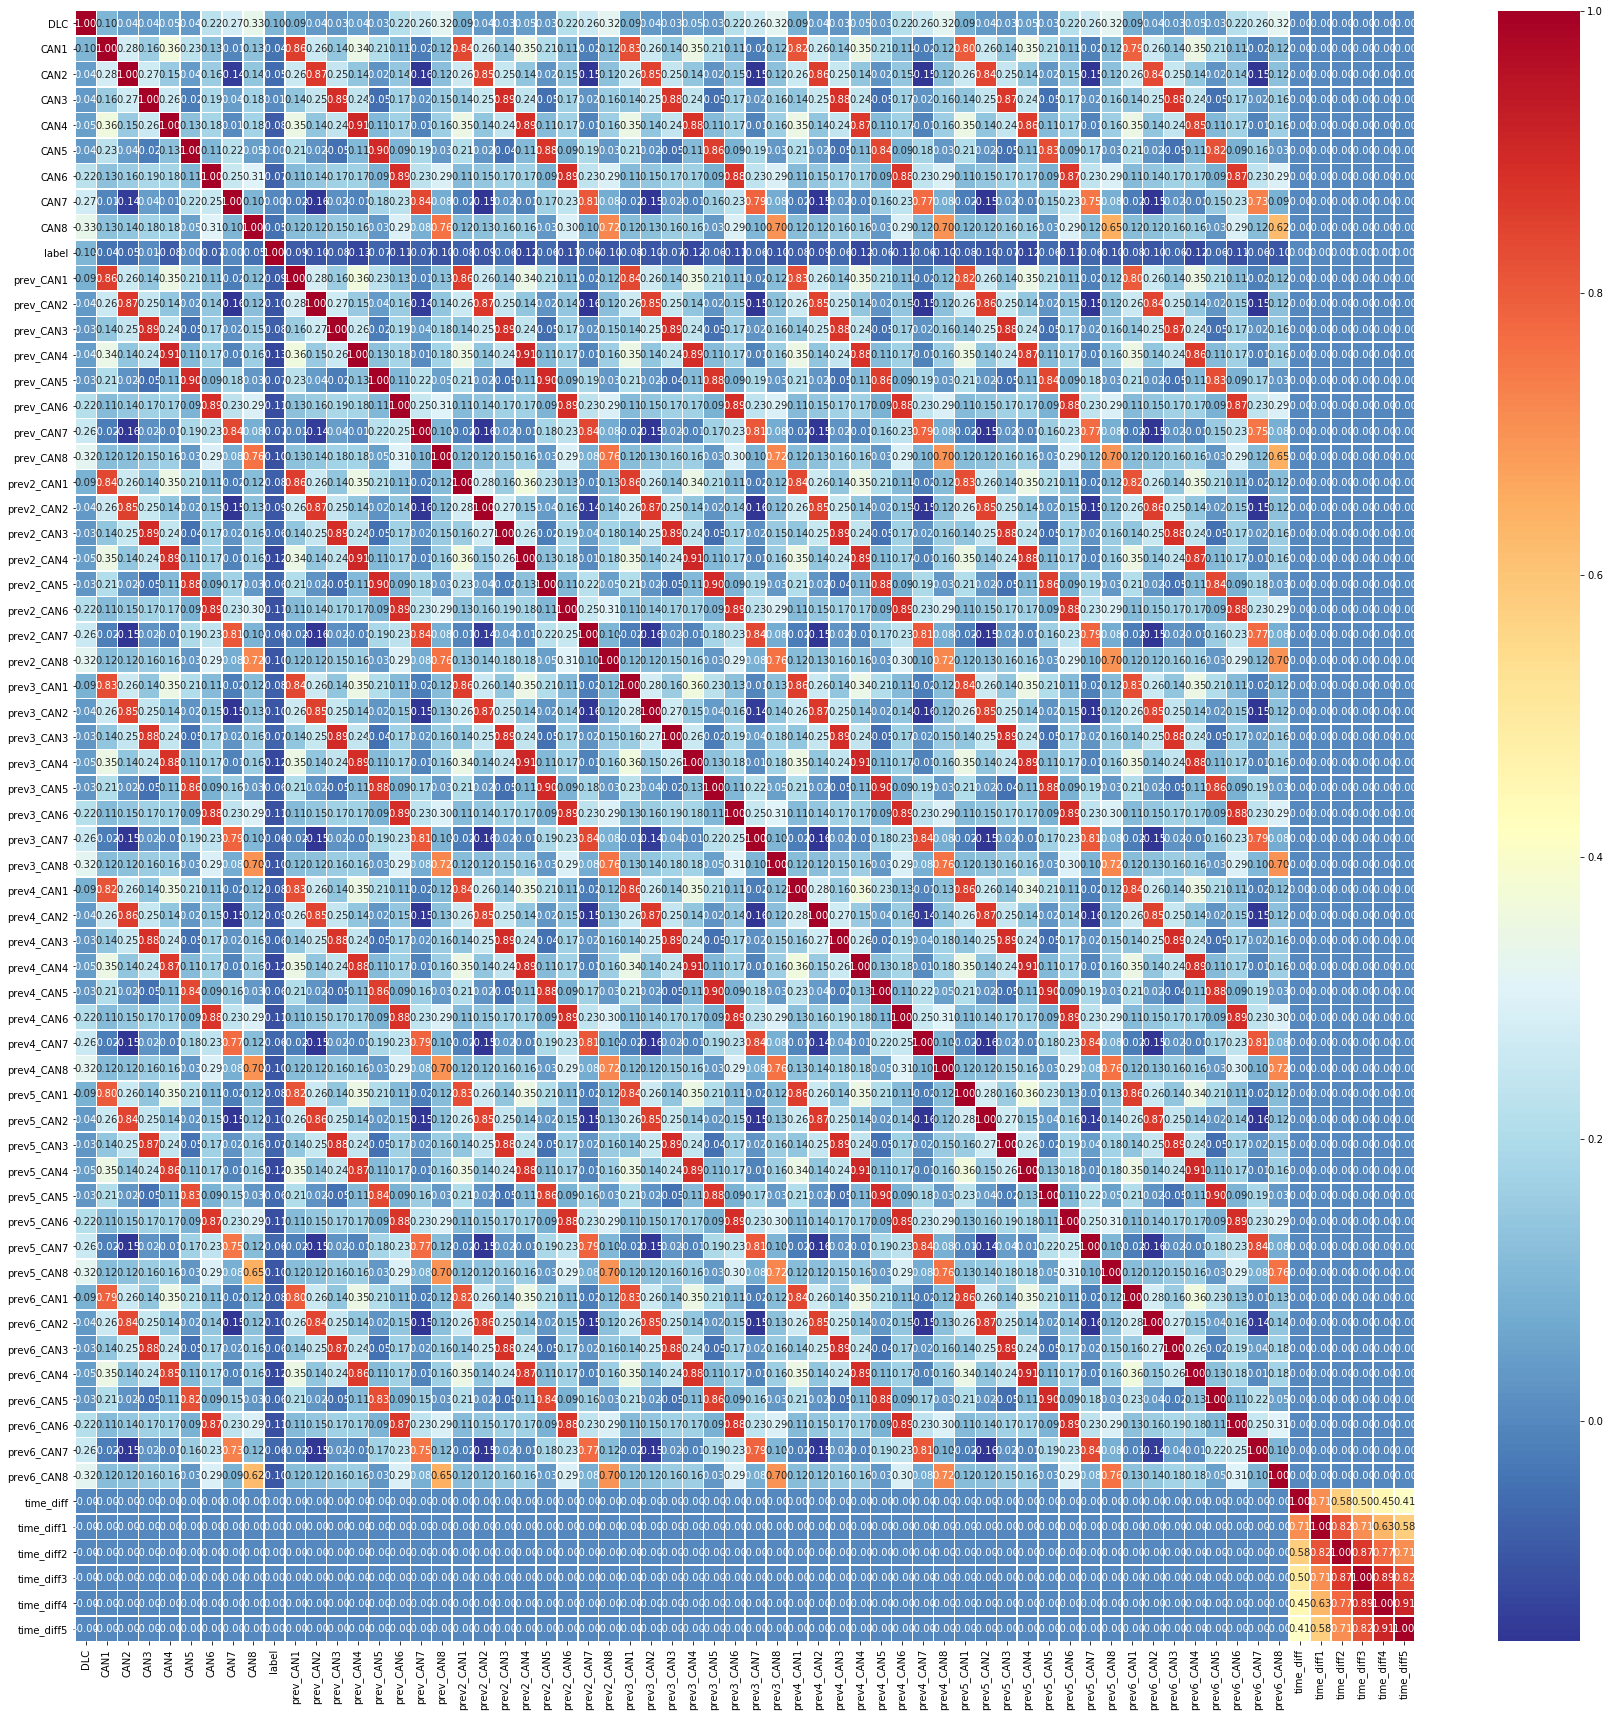

In [154]:
plt.figure(figsize=(30,30))
ax = sns.heatmap(data = train_df.corr(), annot=True,
                fmt = '.2f', cmap = 'RdYlBu_r', linewidths=.5)
buttom, top = ax.get_ylim()
ax.set_ylim(buttom+0.5, top-0.5)
plt.yticks(rotation=0)